In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from itertools import product

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

import gc

In [156]:
path = '~/Git_repo/Adv_ML/data'

In [157]:
train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

#print('Treino \n', train.head(), '\n')
#print('Itens \n', items.head(), '\n')
#print('Itens Cat \n', items_cat.head(), '\n')
#print('Shops \n', shops.head(), '\n')

In [158]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis='columns', inplace=True)
#shops.head()

In [159]:
items_cat['split'] = items_cat['item_category_name'].str.split('-')
items_cat['type'] = items_cat['split'].map(lambda x: x[0].strip())
items_cat['type_code'] = LabelEncoder().fit_transform(items_cat['type'])

items_cat['subtype'] = items_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_cat['subtype_code'] = LabelEncoder().fit_transform(items_cat['subtype'])

items_cat.drop(['item_category_name', 'split', 'type', 'subtype'], axis='columns', inplace=True)
#items_cat.head()

In [160]:
items.drop(['item_name'], axis=1, inplace=True)
#items.head()

In [161]:
train.drop(['date'], axis='columns', inplace=True)
#train.head()

In [162]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [163]:
# Idk with this is true
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [164]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

In [165]:
df_month = train.groupby(by=['date_block_num', 'shop_id', 'item_id'], axis='index').sum()
df_month.rename(columns={'item_cnt_day':'item_cnt_month', 'revenue':'revenue_month'}, inplace=True)
df_month.reset_index(inplace=True)
#df_month.head()

In [166]:
df_month['item_cnt_month'] = df_month['item_cnt_month'].clip(0, 20)

In [167]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(df_month.item_id)))),len(list(set(test.item_id)))

(363, 5100)

In [168]:
# Deixa o set de treino igual ao set de test
#colunas = df_month.columns
#df_month = pd.merge(test, df_month,on = ['item_id','shop_id'],how = 'left').fillna(0)
#df_month = df_month[colunas]

In [169]:
#df_month = pd.merge(aux, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
#del aux

In [170]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(df_month.item_id)))),len(list(set(test.item_id)))


(363, 5100)

In [171]:
df_month = pd.merge(df_month, shops, on=['shop_id'], how='left')
df_month = pd.merge(df_month, items, on=['item_id'], how='left')
df_month = pd.merge(df_month, items_cat, on=['item_category_id'], how='left')

In [172]:
df_month['date_block_num'] = df_month['date_block_num'].astype('int8')
df_month['shop_id'] = df_month['shop_id'].astype('int8')
df_month['item_id'] = df_month['item_id'].astype('int16')
df_month['item_cnt_month'] = df_month['item_cnt_month'].astype('int8')
df_month['item_category_id'] = df_month['item_category_id'].astype('int8')
df_month['revenue_month'] = df_month['revenue_month'].astype('float32')
df_month['city_code'] = df_month['city_code'].astype('int8')
df_month['type_code'] = df_month['type_code'].astype('int8')
df_month['subtype_code'] = df_month['subtype_code'].astype('int8')

In [173]:
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,2,27,2499.0,1,2499.0,0,19,5,10
1,0,2,33,499.0,1,499.0,0,37,11,1
2,0,2,317,299.0,1,299.0,0,45,12,23
3,0,2,438,299.0,1,299.0,0,45,12,23
4,0,2,471,798.0,2,798.0,0,49,12,39


# Simples 

In [174]:
def fit_column_scaler_min_max(minval, maxval, dataframe):
    
    columns = dataframe.columns
    
    scaler = { column : MinMaxScaler(feature_range=(minval, maxval))
              for column in columns}
    
    scaler_fit = [scaler[column].fit_transform(dataframe[[column]])
                  for column in columns]
    
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_fit[idx]
        
    return dataframe, scaler    

In [175]:
def inv_column_scaler_min_max(scaler_data, dataframe):
    
    columns = dataframe.columns
    
    scaler_inv = [scaler_data[column].inverse_transform(dataframe[[column]])
                  for column in columns]
        
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_inv[idx]
        
    return dataframe

In [181]:
df_month.iloc[:, 1:], scaler1 = fit_column_scaler_min_max(0, 1, df_month.iloc[:, 1:])

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [182]:
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,0.0,0.024358,2499.0,1,2499.0,0,19,5,10
1,0,0.0,0.029771,499.0,1,499.0,0,37,11,1
2,0,0.0,0.285985,299.0,1,299.0,0,45,12,23
3,0,0.0,0.395146,299.0,1,299.0,0,45,12,23
4,0,0.0,0.424918,798.0,2,798.0,0,49,12,39


In [183]:
df_lstm1 = df_month.pivot_table(index=['shop_id', 'item_id'],
                               columns=['date_block_num'], values=['item_cnt_month']).fillna(0)
df_lstm1.columns = df_lstm1.columns.droplevel(0)
df_lstm1.reset_index(inplace=True)
df_lstm1.columns.name = None
df_lstm1.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.024358,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.027065,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.027967,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.028869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.029771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [184]:
df_lstm1.shape

(418908, 36)

In [185]:
# Adiciona outras colunas de features
#colunas = ['shop_id','item_id','item_category_id','type_code','subtype_code']
#df_lstm1 = pd.merge(df_lstm1, df_month[colunas], on=['shop_id', 'item_id'], how='left')
#colunas = colunas+[i for i in range(34)]
#df_lstm1 = df_lstm1[colunas]
#df_lstm1.head()

In [186]:
df_lstm1.shape

(418908, 36)

In [187]:
first_month = 2

In [188]:
col = []
col_aux = df_lstm1.columns[0:first_month]

for i in range(34):
    
    col.append(i)
    
    for df_col in col_aux:
        
        if i == 0:
            col.append(df_col)
        else:
            col_name = df_col+str(i)
            col.append(col_name)
            df_lstm1[col_name] = df_lstm1[df_col]
            
df_lstm1 = df_lstm1[col]
df_lstm1.head()

,0,shop_id,item_id,1,shop_id1,item_id1,2,shop_id2,item_id2,3,...,item_id30,31,shop_id31,item_id31,32,shop_id32,item_id32,33,shop_id33,item_id33
0,1.0,0.0,0.024358,0.0,0.0,0.024358,0.0,0.0,0.024358,0.0,...,0.024358,0.0,0.0,0.024358,0.0,0.0,0.024358,0.0,0.0,0.024358
1,0.0,0.0,0.027065,0.0,0.0,0.027065,1.0,0.0,0.027065,0.0,...,0.027065,0.0,0.0,0.027065,0.0,0.0,0.027065,0.0,0.0,0.027065
2,0.0,0.0,0.027967,4.0,0.0,0.027967,1.0,0.0,0.027967,1.0,...,0.027967,0.0,0.0,0.027967,0.0,0.0,0.027967,1.0,0.0,0.027967
3,0.0,0.0,0.028869,0.0,0.0,0.028869,0.0,0.0,0.028869,0.0,...,0.028869,1.0,0.0,0.028869,0.0,0.0,0.028869,0.0,0.0,0.028869
4,1.0,0.0,0.029771,0.0,0.0,0.029771,0.0,0.0,0.029771,0.0,...,0.029771,0.0,0.0,0.029771,1.0,0.0,0.029771,0.0,0.0,0.029771


In [189]:
x_train1 = df_lstm1.iloc[:, :(-first_month-1)].values
y_train1 = df_lstm1[33]

x_train1.shape, y_train1.shape

((418908, 99), (418908,))

In [190]:
time_step1 = 33
features1 = np.around(x_train1.shape[1] / 33).astype(np.int16)
n_samples1 = x_train1.shape[0]
'Time:', time_step1, 'Features:', features1, 'Samples:', n_samples1

('Time:', 33, 'Features:', 3, 'Samples:', 418908)

In [191]:
x_train1  = x_train1.reshape((n_samples1, time_step1, features1))

x_train1.shape, y_train1.shape

((418908, 33, 3), (418908,))

In [192]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(time_step1, features1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64, input_shape=(time_step1, features1)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 33, 32)            4608      
_________________________________________________________________
dropout_9 (Dropout)          (None, 33, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 29,505
Trainable params: 29,505
Non-trainable params: 0
_________________________________________________________________


In [197]:
history = model.fit(x_train1, y_train1, batch_size = 4096, epochs = 13, shuffle=False)

Epoch 1/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5561 - mean_squared_error: 0.5561
Epoch 2/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5581 - mean_squared_error: 0.5581
Epoch 3/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5543 - mean_squared_error: 0.5543
Epoch 4/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5527 - mean_squared_error: 0.5527
Epoch 5/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5538 - mean_squared_error: 0.5538
Epoch 6/20
418908/418908 [==============================] - 16s 39us/step - loss: 0.5517 - mean_squared_error: 0.5517
Epoch 7/20
418908/418908 [==============================] - 17s 39us/step - loss: 0.5530 - mean_squared_error: 0.5530
Epoch 8/20
418908/418908 [==============================] - 17s 41us/step - loss: 0.5524 - mean_squared_error: 0.5524
Epoch 9/20
418908/418908 [==============================

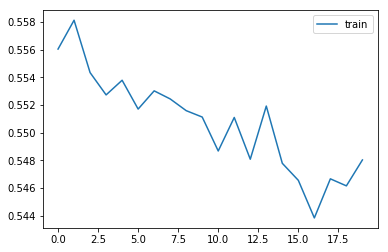

In [198]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [113]:
pred1 = df_lstm1.iloc[:, (first_month+1):].values.reshape((n_samples1, time_step1, features1))

In [114]:
yhat = model.predict(pred1)

In [115]:
a = y_train1.values.reshape((-1,1))#scaler1['item_cnt_month'].inverse_transform(y_train1.values.reshape((-1,1)))
b = yhat#scaler1['item_cnt_month'].inverse_transform(yhat)
rmse = np.sqrt(mean_squared_error(a, b))
print('Test RMSE: %.3f' % rmse) #0.565 ~ 0.534

Test RMSE: 0.675


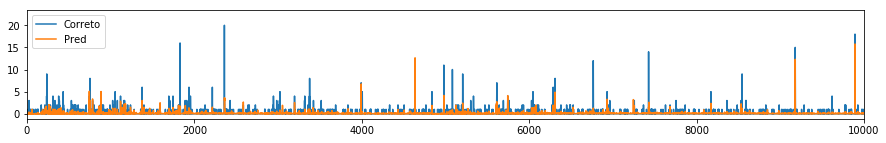

In [116]:
plt.figure(figsize=(15,2))
plt.plot(a, label='Correto')
plt.plot(b, label='Pred')
plt.xlim(0,10000)
plt.legend()
plt.show()

In [117]:
df_test1 = df_lstm1[['shop_id', 'item_id']]
df_test1['item_cnt_month'] = yhat
df_test1.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,shop_id,item_id,item_cnt_month
0,0.0,0.001218,-0.000838
1,0.0,0.001353,-0.000832
2,0.0,0.001398,0.000866
3,0.0,0.001443,0.001622
4,0.0,0.001489,0.004027


In [118]:
col = ['shop_id', 'item_id', 'item_cnt_month']
df_test1[col] = inv_column_scaler_min_max(scaler1, df_test1[col])
df_test1['item_cnt_month'] = df_test1['item_cnt_month'].clip(0,20)
df_test1.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,shop_id,item_id,item_cnt_month
0,2.0,27.0,0.000000
1,2.0,30.0,0.000000
2,2.0,31.0,0.017329
3,2.0,32.0,0.032445
4,2.0,33.0,0.080533


In [119]:
df_sub1 = pd.merge(test, df_test1, how='left').fillna(0)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": df_sub1['item_cnt_month']
})

submission.to_csv('LSTM_submission.csv', index=False)

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [120]:
submission.head()

,ID,item_cnt_month
0,0,0.527623
1,1,0.000000
2,2,0.680389
3,3,0.116735
4,4,0.000000


In [ ]:
gc.collect()

------------------